## Tracking position of a ball executing a projectile motion
A Ball fired through a cannon at an angle under the influence of gravity executes what is called as the Projectile motion

The physics governing this motion can be represented as 

$ y = y_0 + v_{y0} t + \frac{1}{2} g t^2 $

$ x = x_0 + v_{x0} t $

$\frac{d^2 y}{dt} = g$

$\frac{d x}{dt} = v_{x0}$

where,

$t$ is the time in seconds

$g = -9.8 \frac{m}{s^2}$ is the acceleration due to gravity 

If $v_0$ is the initial velocity of ball launched at an angle of $\theta$

$v_{x0} = v_0 \times cos(\theta)$

$v_{y0} = v_0 \times sin(\theta)$

However, we know that the model is not perfect and there are unmodelled effects due to air drag and hence there is a Process noise

Also, we will assume that we have a computer vision system that looks down on this planar motion and is able to segment the ball as a blob using image segmentation and provide $(x,y)$ position of the ball

The measurment also is not perfect and is noisy which we can model as a gaussian noise

Given the Process Noise and measurement noise, your task is to provide the optimal estimate for the position of the ball using kalman filter

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
%matplotlib widget

In [3]:
# Assume independent and uncorrelated noise for Process and Measurement
# You can play around with these values to see how the filter performs
Q = np.diag([0.01, 0.1, 0.1, 0.001]) ** 2
R = np.diag([0.05, 0.05]) ** 2

In [4]:
# Sim Params
# You can change and experiment with these
dt = 0.01
N = 102
v_0 = 10
theta = math.pi / 6

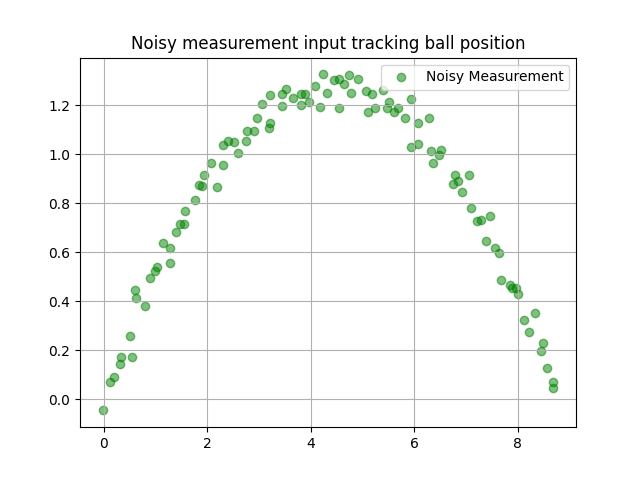

In [5]:
# Create some noisy measurement data - You don't have to modify this part
g = -9.81

v_y = v_0 * math.sin(theta)
v_x = v_0 * math.cos(theta)
top_y = (v_0 * math.sin(theta)) ** 2 / (2 * 9.81)

zs_y = np.zeros(N)
zs_x = np.zeros(N)

for i in range(1,N):
    zs_y[i] = zs_y[i-1] + v_y * dt  + g  * (dt ** 2) / 2
    v_y = v_y + g * dt
    zs_x[i] = zs_x[i-1] + v_x * dt

Zs = np.vstack((zs_x, zs_y))
Z_noisy = list()

Z_noisy = [np.array([[Zs[0,i]], [Zs[1,i]]]) + (np.random.multivariate_normal(np.zeros(2), R, 1)).T for i in range(N)]
    
z_noisy_x = [z[0,0] for z in Z_noisy]
z_noisy_y = [z[1,0] for z in Z_noisy]

plt.figure()
plt.title('Noisy measurement input tracking ball position')
plt.grid()
plt.scatter(z_noisy_x, z_noisy_y, c='g', alpha=0.5, label='Noisy Measurement')
plt.legend()

## Choose State variables (and control input)
Break down the equations above as first order differential equations

_Hint: the gravitational constant can be treated as a control input_



## Write down the state transition equation
$\bar{X} = FX + BU$

Write matrices for $F$ and $B$,



In [6]:
def state_transition(X):
    """
    :param X: np array of size 4 x 1 representing the State at t-1 
    :return Updated State after one iteration of state update
    """
    # Your code here
    F = np.array([[1, dt, 0, 0], [0, 1, 0, 0], [0, 0, 1, dt], [0 , 0, 0, 1]]) # State transition Matrix
    B = np.eye(4) # Control change Matrix
    G = 9.8
    X_new = np.dot(F,X)+np.dot(B,G)
    return X_new

In [7]:
def predictor(X, P):
    """
    :param X: np array of size 4 x 1 representing State at t-1
    :param P: np array of size 4 x 4 representing Covariance Estimate at t-1
    :return X_pred,P_pred: A tuple of updated state and its covariance
    """
    # Your code here
    X_pred = state_transition(X)
    F = np.array([[1, dt, 0, 0], [0, 1, 0, 0], [0, 0, 1, dt], [0 , 0, 0, 1]])
    P_pred = F @ P @ F.T + Q
    return X_pred, P_pred    

## Find the Measurement function
$ z = HX$

Since, only observed variables are position of the ball, write the $H$ matrix

In [8]:
def measurement_function(X):
    """
    :param X: np array of size 4x1 Predicted State of t
    :return Mapped state to measurement space using measurment matrix H
    """
    # Your code here
    H = np.array([[1, 0, 0, 0], [0, 0, 1, 0]])
    return H @ X

In [9]:
def corrector(X, P, z):
    """
    :param X:  np array of size 4x1 representing State after incorporating prediction
    :parm P:  np array of size 4x4 representing Covariance after incorporating prediction
    :parm z: np array of size 2 x 1 representing the measurement x, y at the current time instant
    :return X_est, P_est: tuple of Estimated state and covariance after measurement update
    """
    # Your code here
    H = np.array([[1, 0, 0, 0], [0, 0, 1, 0]])
    K = P @ H.T @ np.linalg.inv(H @ P @ H.T + R)
    X_est = X + K @ (z - measurement_function(X))
    P_est = (np.eye(4) - K @ H) @ P
    return X_est, P_est    

## Initial Conditions
Assuming, $x = 0  \quad and \quad y = 0$;

$v_0 = 10$ and $\theta = 30$ degrees

Assign proper values to $X_0$ and $P_0$


In [10]:
def getInitialStateAndCovariance():
    """
    :return initial state and covariance matrix
    
    initial state should be a numpy array of size 4 x 1
    Covariance should be covariance matrix of size 4 x 4
    """
    X0 = np.zeros((4,1))
    P0 = np.zeros((4,4))
    
    # Your code here
    
    return X0, P0

In [11]:
# Simulate
X, P = getInitialStateAndCovariance() 
X_est, P_est = corrector(X, P, Z_noisy[0])
print("X_est {}, P_est {}".format(X_est,P_est))
Xs = [X_est]
Ps = [P_est]
print("Xs {}, Ps {}".format(Xs,Ps))
for i in range(1, N):
    X_pred, P_pred = predictor(X_est, P_est)
    if i % 2 == 0: # Choose the frequency of update
        X_est, P_est = corrector(X_pred, P_pred, Z_noisy[i])
    else:
        X_est = X_pred
        P_est = P_pred
        
    Xs.append(X_est)
    Ps.append(P_est)
print("After Loop Xs {}, Ps {}".format(Xs,Ps))

X_est [[0.]
 [0.]
 [0.]
 [0.]], P_est [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Xs [array([[0.],
       [0.],
       [0.],
       [0.]])], Ps [array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])]
After Loop Xs [array([[0.],
       [0.],
       [0.],
       [0.]]), array([[9.8, 0. , 0. , 0. ],
       [0. , 9.8, 0. , 0. ],
       [0. , 0. , 9.8, 0. ],
       [0. , 0. , 0. , 9.8]]), array([[ 1.81558826e+01,  1.05160643e-01,  1.44534975e-02,
         1.44534975e-02],
       [-7.18466369e-01,  1.96035625e+01,  7.19079480e-03,
         7.19079480e-03],
       [ 8.25712349e-02,  8.25712349e-02,  2.26034900e+00,
         9.34601238e-02],
       [ 4.12856173e-08,  4.12856173e-08, -8.66982546e-06,
         1.96000000e+01]]), array([[ 2.79486979e+01,  3.01196268e-01,  1.45254055e-02,
         1.45254055e-02],
       [-7.18466369e-01,  2.94035625e+01,  7.19079480e-03,
         7.19079480e-03],
       [ 8.25712353e-02,  8.25712353e

d:\programfiles\python39\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


ValueError: setting an array element with a sequence.

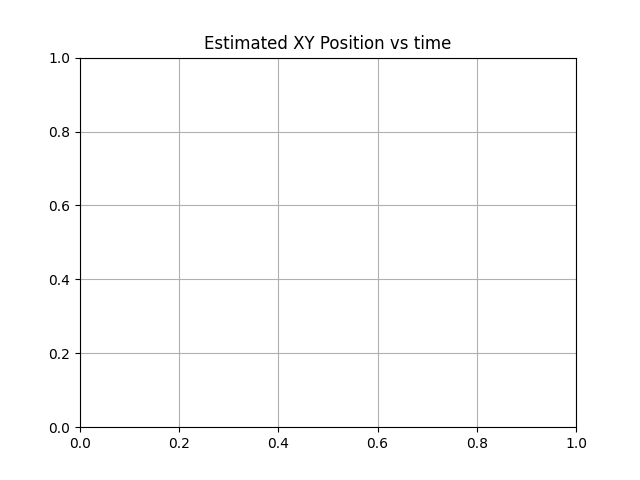

In [12]:
# Plot Trajectory
fig, ax = plt.subplots()
X_pts = [X[0] for X in Xs]
Y_pts = [X[2] for X in Xs]

Z_n_x = [z_n[0] for z_n in Z_noisy]
Z_n_y = [z_n[1] for z_n in Z_noisy]

plt.grid()
plt.title("Estimated XY Position vs time")
ax.plot(X_pts, Y_pts, label="Robot Trajectory")

ax.scatter(Z_n_x, Z_n_y, marker='o', c='green', label="Measurements")

plt.legend()

## Optional
1. Tune the noise parameters to smoothen the trajectory
2. Evalute the filter and verify that error between measured state and estimated state is within bounds of covariance matrix